# Berlin Climate Analysis 1949-2022

This notebook examines the weather data of Berlin from 1949-2022, sourced from the European Climate Assessment & Dataset (ECA&D). Through data visualization, we explore the yearly, monthly, and daily rolling temperature (°C), precipitation (mm), sea level pressure (hPa), sunshine duration (hours), and wind speed (m/s) to identify trends and relationships. Additionally, this notebook showcases basic data wrangling techniques, including merging, filtering, feature extraction, and missing value imputation.
## Data Preparation

### Importing Modules
The necessary modules are imported to read and manipulate the data.

In [1135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import math

###  Read and Merge Data into a DataFrame
The weather data is loaded from five different files into separate dataframes and concatenated into one dataframe. The columns are renamed, the index is set to the date, and the data is filtered to only include dates from 1949 to 2022.

In [1136]:
file_names = ['berlin_avg_temp', 'berlin_precipitation', 'berlin_sea_level', 'berlin_sunshine', 'berlin_wind_speed']
dfs = []

for file_name in file_names:
    df = pd.read_csv(f'data/eca/{file_name}.txt', delimiter=',').rename(columns=str.strip)
    df = df[(df['DATE'] >= 19490101) & (df['DATE'] <= 20221231)].set_index('DATE')
    df.index = pd.to_datetime(df.index, format='%Y%m%d')
    dfs.append(df)
df = pd.concat(dfs, axis=1)
df = df[['TG', 'RR', 'PP', 'SS', 'FG']].rename_axis(None)
df = df.rename(columns={'TG': 'temp', 'RR': 'prec', 'PP': 'pres', 'SS': 'sunh', 'FG': 'wind'})
df_copy = df.copy() # make a copy of the original data for later
print(df.head())

            temp  prec   pres  sunh  wind
1949-01-01    36     0   9964     0 -9999
1949-01-02    35    60   9939     0 -9999
1949-01-03    34    30  10022    35 -9999
1949-01-04    14     0  10129    43 -9999
1949-01-05    18     0  10246    20 -9999


### Preparing Data for Time Series Analysis
The date column is converted to datetime and used as the index for the dataframe to enable easy analysis and visualization of the weather data over time.

In [1137]:
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
print(df.head())

            temp  prec   pres  sunh  wind  year  month  day
1949-01-01    36     0   9964     0 -9999  1949      1    1
1949-01-02    35    60   9939     0 -9999  1949      1    2
1949-01-03    34    30  10022    35 -9999  1949      1    3
1949-01-04    14     0  10129    43 -9999  1949      1    4
1949-01-05    18     0  10246    20 -9999  1949      1    5


## Handling Missing Values

### Linear interpolation
Interpolation is used to fill in missing values based on neighboring points in time, providing a more accurate representation of the trends. This approach is suitable for datasets with sparse missing values and a smooth temporal structure.

In [1138]:
def replace_missing_values(df):
    
    for col in df.columns[0:4]:
        missing_rows = df.loc[df[col] == -9999]
        if len(missing_rows) == 0:
            continue
        for index, row in missing_rows.iterrows():
            prev_year_val = None
            year = index.year
            while prev_year_val is None and year >= df.index.min().year:
                try:
                    prev_year_val = df.loc[f'{year-1}-{index.month}-{index.day}'][col]
                except KeyError:
                    # Handle leap year
                    if index.month == 2 and index.day == 29:
                        prev_year_val = df.loc[f'{year-1}-02-28'][col]
                    year -= 1
            next_year_val = None
            year = index.year
            while next_year_val is None and year <= df.index.max().year:
                try:
                    next_year_val = df.loc[f'{year+1}-{index.month}-{index.day}'][col]
                except KeyError:
                    # Handle leap year
                    if index.month == 2 and index.day == 29:
                        next_year_val = df.loc[f'{year+1}-03-01'][col]
                    year += 1
            if prev_year_val is None:
                prev_year_val = 0
            if next_year_val is None:
                next_year_val = 0
            df.at[index, col] = (prev_year_val + next_year_val) / 2
    return df

print(df)

            temp  prec   pres  sunh  wind  year  month  day
1949-01-01    36     0   9964     0 -9999  1949      1    1
1949-01-02    35    60   9939     0 -9999  1949      1    2
1949-01-03    34    30  10022    35 -9999  1949      1    3
1949-01-04    14     0  10129    43 -9999  1949      1    4
1949-01-05    18     0  10246    20 -9999  1949      1    5
...          ...   ...    ...   ...   ...   ...    ...  ...
2022-12-27    42     0  10207    22    46  2022     12   27
2022-12-28    63    15  10154    13    46  2022     12   28
2022-12-29   100    18  10055    24    48  2022     12   29
2022-12-30    76    20  10110    62    41  2022     12   30
2022-12-31   148     0  10076     6    59  2022     12   31

[27028 rows x 8 columns]


### Median Imputation

The earlier approach of filling in missing values by interpolation relies on the assumption that there is a smooth temporal relationship between data points. In the case of wind speed, the absence of reliable data for wind speed from 1949-1973, was filled with the missing values using the median is a reasonable approach.

In [1139]:
df['wind'] = df['wind'].replace(-9999, np.nan)
df['wind'].fillna(df['wind'].median(), inplace=True)
print(df)

            temp  prec   pres  sunh  wind  year  month  day
1949-01-01    36     0   9964     0  36.0  1949      1    1
1949-01-02    35    60   9939     0  36.0  1949      1    2
1949-01-03    34    30  10022    35  36.0  1949      1    3
1949-01-04    14     0  10129    43  36.0  1949      1    4
1949-01-05    18     0  10246    20  36.0  1949      1    5
...          ...   ...    ...   ...   ...   ...    ...  ...
2022-12-27    42     0  10207    22  46.0  2022     12   27
2022-12-28    63    15  10154    13  46.0  2022     12   28
2022-12-29   100    18  10055    24  48.0  2022     12   29
2022-12-30    76    20  10110    62  41.0  2022     12   30
2022-12-31   148     0  10076     6  59.0  2022     12   31

[27028 rows x 8 columns]


### Data Units Adjustment

The data units reported by ECA&D were adjusted by dividing the values by 10 to enable accurate interpretation and analysis of the data.

In [1140]:
for col in df.columns[0:4]:
    df[col] = df[col] / 10
print(df)

            temp  prec    pres  sunh  wind  year  month  day
1949-01-01   3.6   0.0   996.4   0.0  36.0  1949      1    1
1949-01-02   3.5   6.0   993.9   0.0  36.0  1949      1    2
1949-01-03   3.4   3.0  1002.2   3.5  36.0  1949      1    3
1949-01-04   1.4   0.0  1012.9   4.3  36.0  1949      1    4
1949-01-05   1.8   0.0  1024.6   2.0  36.0  1949      1    5
...          ...   ...     ...   ...   ...   ...    ...  ...
2022-12-27   4.2   0.0  1020.7   2.2  46.0  2022     12   27
2022-12-28   6.3   1.5  1015.4   1.3  46.0  2022     12   28
2022-12-29  10.0   1.8  1005.5   2.4  48.0  2022     12   29
2022-12-30   7.6   2.0  1011.0   6.2  41.0  2022     12   30
2022-12-31  14.8   0.0  1007.6   0.6  59.0  2022     12   31

[27028 rows x 8 columns]


## Data Visualization

The median is a good measure for detecting climate trends because it is less sensitive to extreme values or outliers in the dataset than other measures of central tendency, such as the mean. In statistics, median refers to the middle value when a dataset is ordered from least to greatest, or the average of the two middle values when the dataset has an even number of values.

### Climate Stripes
Climate stripes help us visualize how temperature changes over time, where each stripe represents a year.


Warmest years in [2018, 2014, 1949] reaching [12.2, 11.9, 11.6] °C,
Coolest years in [1973, 1956, 1958] reaching [8.0, 8.25, 8.4] °C.



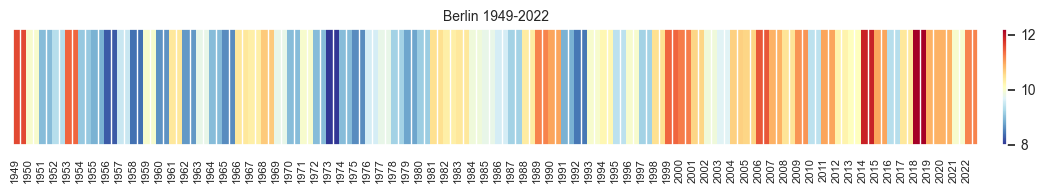

In [1141]:
years = range(1949, 2023)

df_temp = df.groupby('year')['temp'].median()
df_temp_list = df_temp.tolist()
print(f"""
Warmest years in {df_temp.nlargest(3).index.tolist()} reaching {df_temp.nlargest(3).tolist()} °C,
Coolest years in {df_temp.nsmallest(3).index.tolist()} reaching {df_temp.nsmallest(3).tolist()} °C.
""")

# Define the color map and normalization
cmap = plt.cm.get_cmap('RdYlBu_r')
norm = plt.Normalize(np.min(df_temp_list), np.max(df_temp_list))
fig, ax = plt.subplots(figsize=(15, 1.5))
image = ax.imshow([df_temp_list], cmap=cmap, aspect='auto', norm=norm)
cbar = plt.colorbar(image, ax=ax, orientation='vertical', pad=0.02)
cbar.ax.tick_params(labelsize=10)
cbar.ax.tick_params(axis='x', pad=10)  # add a margin on top
ax.set_xticks(np.linspace(0, len(df_temp_list)-1, len(years)))
ax.set_xticklabels(years, fontsize=8, rotation=90, ha='right')
ax.set_yticks([])
ax.set_ylabel('')
plt.title('Berlin 1949-2022', fontsize=10)
plt.show()

### Precipitation Map
A heatmap visualisation can be used to represent precipitation data, where the darkest hue indicates a higher amount of precipitation.

Between 1949 and 2022, Berlin experienced no precipitation in 511 months.
Highest precipitation amounts reported on [(1974, 12), (1976, 1), (1988, 2)]
with [3.0, 2.6, 2.2]mm. 


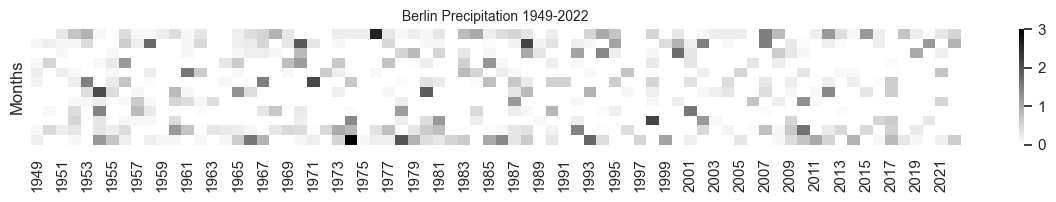

In [1142]:
df_monthly_prec = df.groupby(['year', 'month'])['prec'].median().unstack().T

num_zeros = df_monthly_prec.eq(0).sum().sum()
print(f"""Between 1949 and 2022, Berlin experienced no precipitation in {num_zeros} months.
Highest precipitation amounts reported on {df_monthly_prec.unstack().nlargest(3).index.tolist()}
with {df_monthly_prec.unstack().nlargest(3).tolist()}mm. """)

# Create heatmap
fig, ax = plt.subplots(figsize=(15, 1.5))
sns.heatmap(df_monthly_prec, cmap='gray_r', ax=ax)
ax.set_xlabel('')
ax.set_ylabel('Months')
ax.set_yticks([])
plt.title('Berlin Precipitation 1949-2022', fontsize=10)
plt.show()

### Sea Level Pressure

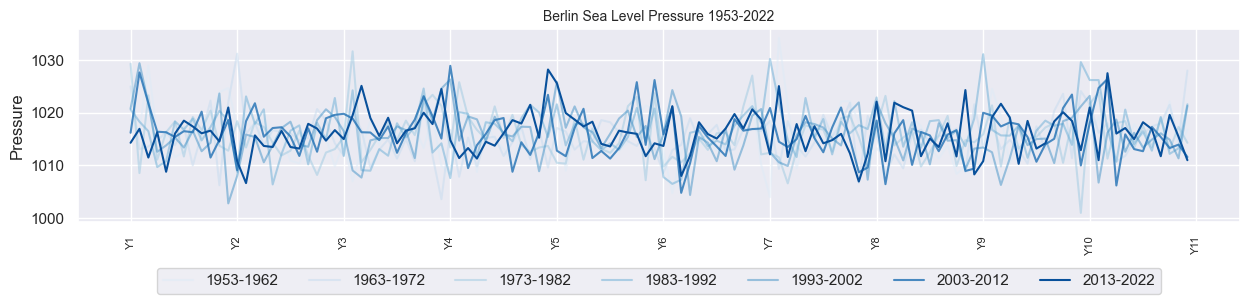

In [1143]:
df_pres_1950 = df.loc['1953-01-01':'1962-12-31'].groupby(['year', 'month'])['pres'].median().unstack()
df_pres_1960 = df.loc['1963-01-01':'1972-12-31'].groupby(['year', 'month'])['pres'].median().unstack()
df_pres_1970 = df.loc['1973-01-01':'1982-12-31'].groupby(['year', 'month'])['pres'].median().unstack()
df_pres_1980 = df.loc['1983-01-01':'1992-12-31'].groupby(['year', 'month'])['pres'].median().unstack()
df_pres_1990 = df.loc['1993-01-01':'2002-12-31'].groupby(['year', 'month'])['pres'].median().unstack()
df_pres_2000 = df.loc['2003-01-01':'2012-12-31'].groupby(['year', 'month'])['pres'].median().unstack()
df_pres_2010 = df.loc['2013-01-01':'2022-12-31'].groupby(['year', 'month'])['pres'].median().unstack()

pres_1950_list = df_pres_1950.values.flatten().tolist()
pres_1960_list = df_pres_1960.values.flatten().tolist()
pres_1970_list = df_pres_1970.values.flatten().tolist()
pres_1980_list = df_pres_1980.values.flatten().tolist()
pres_1990_list = df_pres_1990.values.flatten().tolist()
pres_2000_list = df_pres_2000.values.flatten().tolist()
pres_2010_list = df_pres_2010.values.flatten().tolist()

# Create a list of all the pressure lists
sns.set(style="darkgrid")
colors = sns.color_palette("Blues", n_colors=7)

plt.figure(figsize=(15, 2.5))
sns.lineplot(x=range(len(pres_1950_list)), y=pres_1950_list, label='1953-1962', color=colors[0], alpha=0.5)
sns.lineplot(x=range(len(pres_1960_list)), y=pres_1960_list, label='1963-1972', color=colors[1], alpha=0.5)
sns.lineplot(x=range(len(pres_1970_list)), y=pres_1970_list, label='1973-1982', color=colors[2], alpha=0.5)
sns.lineplot(x=range(len(pres_1980_list)), y=pres_1980_list, label='1983-1992', color=colors[3], alpha=0.5)
sns.lineplot(x=range(len(pres_1990_list)), y=pres_1990_list, label='1993-2002', color=colors[4], alpha=0.5)
sns.lineplot(x=range(len(pres_2000_list)), y=pres_2000_list, label='2003-2012', color=colors[5], alpha=0.8)
sns.lineplot(x=range(len(pres_2010_list)), y=pres_2010_list, label='2013-2022', color=colors[6])

plt.xticks(np.arange(0, 121, 12), ['Y{}'.format(i+1) for i in range(11)], fontsize=8, rotation=90, ha='center')
plt.title('Berlin Sea Level Pressure 1953-2022', fontsize=10)
plt.legend(bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=7)
plt.ylabel("Pressure")
plt.show()


### Sunshine Hours
Sunshine hours refer to the total time during the day when the sun is above the horizon and is visible to an observer. It is the duration between sunrise and sunset when the sunlight reaches the ground without obstruction.  Sunshine hours are a more specific measure of the amount of time the sun is visible and shining on a location, while daytime is a more general measure of the length of the period between sunrise and sunset.


Peak Sunshine years in [2018, 1953, 1982] with [5.8, 5.5, 5.2] hours,
Lowest Sunshine years in [2013, 2010, 1966] with [2.1, 2.2, 2.5] hours.



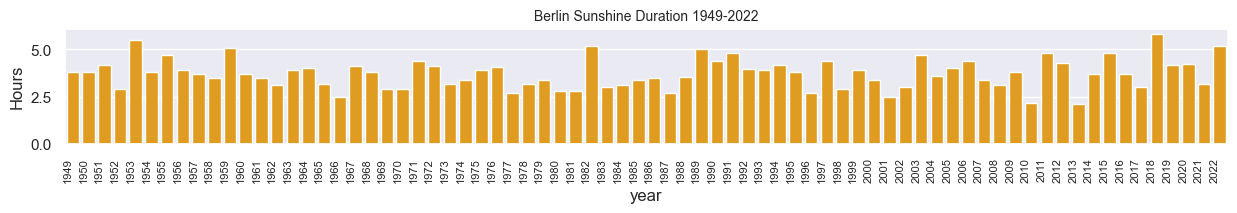

In [1144]:
df_sunh = df.groupby('year')['sunh'].median()
print(f"""
Peak Sunshine years in {df_sunh.nlargest(3).index.tolist()} with {df_sunh.nlargest(3).tolist()} hours,
Lowest Sunshine years in {df_sunh.nsmallest(3).index.tolist()} with {df_sunh.nsmallest(3).tolist()} hours.
""")
      
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(15, 1.5))
sns.barplot(x=df_sunh.index, y=df_sunh.values, color='orange')
ax.set_xticklabels(years, fontsize=8, rotation=90, ha='right')
plt.ylabel('Hours')
plt.title('Berlin Sunshine Duration 1949-2022', fontsize=10)
plt.show()


Strongest wind speed in [1974, 1998, 1979] reaching [42.0, 40.0, 39.0] m/s,
Weakest wind speed in [2016, 2020, 2021] reaching [32.0, 33.0, 33.0] m/s.



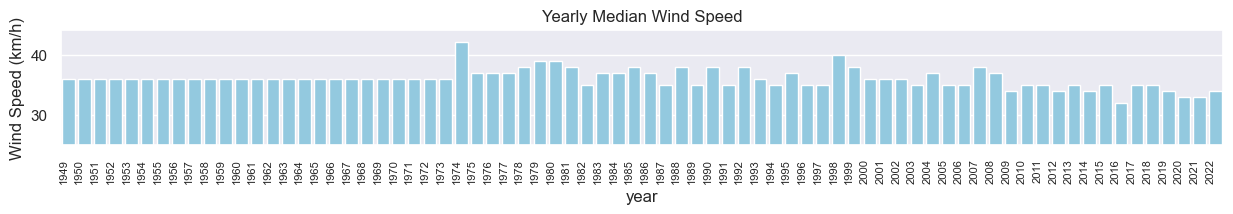

In [1154]:
df_wind = df.groupby('year')['wind'].median()
print(f"""
Strongest wind speed in {df_wind.nlargest(3).index.tolist()} reaching {df_wind.nlargest(3).tolist()} m/s,
Weakest wind speed in {df_wind.nsmallest(3).index.tolist()} reaching {df_wind.nsmallest(3).tolist()} m/s.
""")

sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(15, 1.5))
sns.barplot(x=df_wind.index, y=df_wind.values, color='skyblue')
plt.title('Yearly Median Wind Speed')
ax.set_xticklabels(years, fontsize=8, rotation=90, ha='right')
ax.set_ylim(25, ax.get_ylim()[1]) # set y-axis limit to start from 25
plt.ylabel('Wind Speed (km/h)')
plt.show()

### Findings

* The climate stripe graph shows the temperature changes in Berlin from 1949 to 2022, with warmer colors indicating higher temperatures. The years [2018, 2014, 1949] were the warmest, with peak temperatures of [12.2, 11.9, 11.6] °C, respectively. On the other hand, the coolest years were [1973, 1956, 1958], with temperatures reaching [8.0, 8.25, 8.4] °C., respectively.
* Between 1949 and 2022, Berlin experienced no precipitation in 511 months. The highest monthly median precipitation amounts were reported in December 1974, January 1976, and February 1988, with 3.0mm, 2.6mm, and 2.2mm, respectively.

## Exploring Pairwise Relationships
Exploring Pairwise Relationships between Variables using visualization

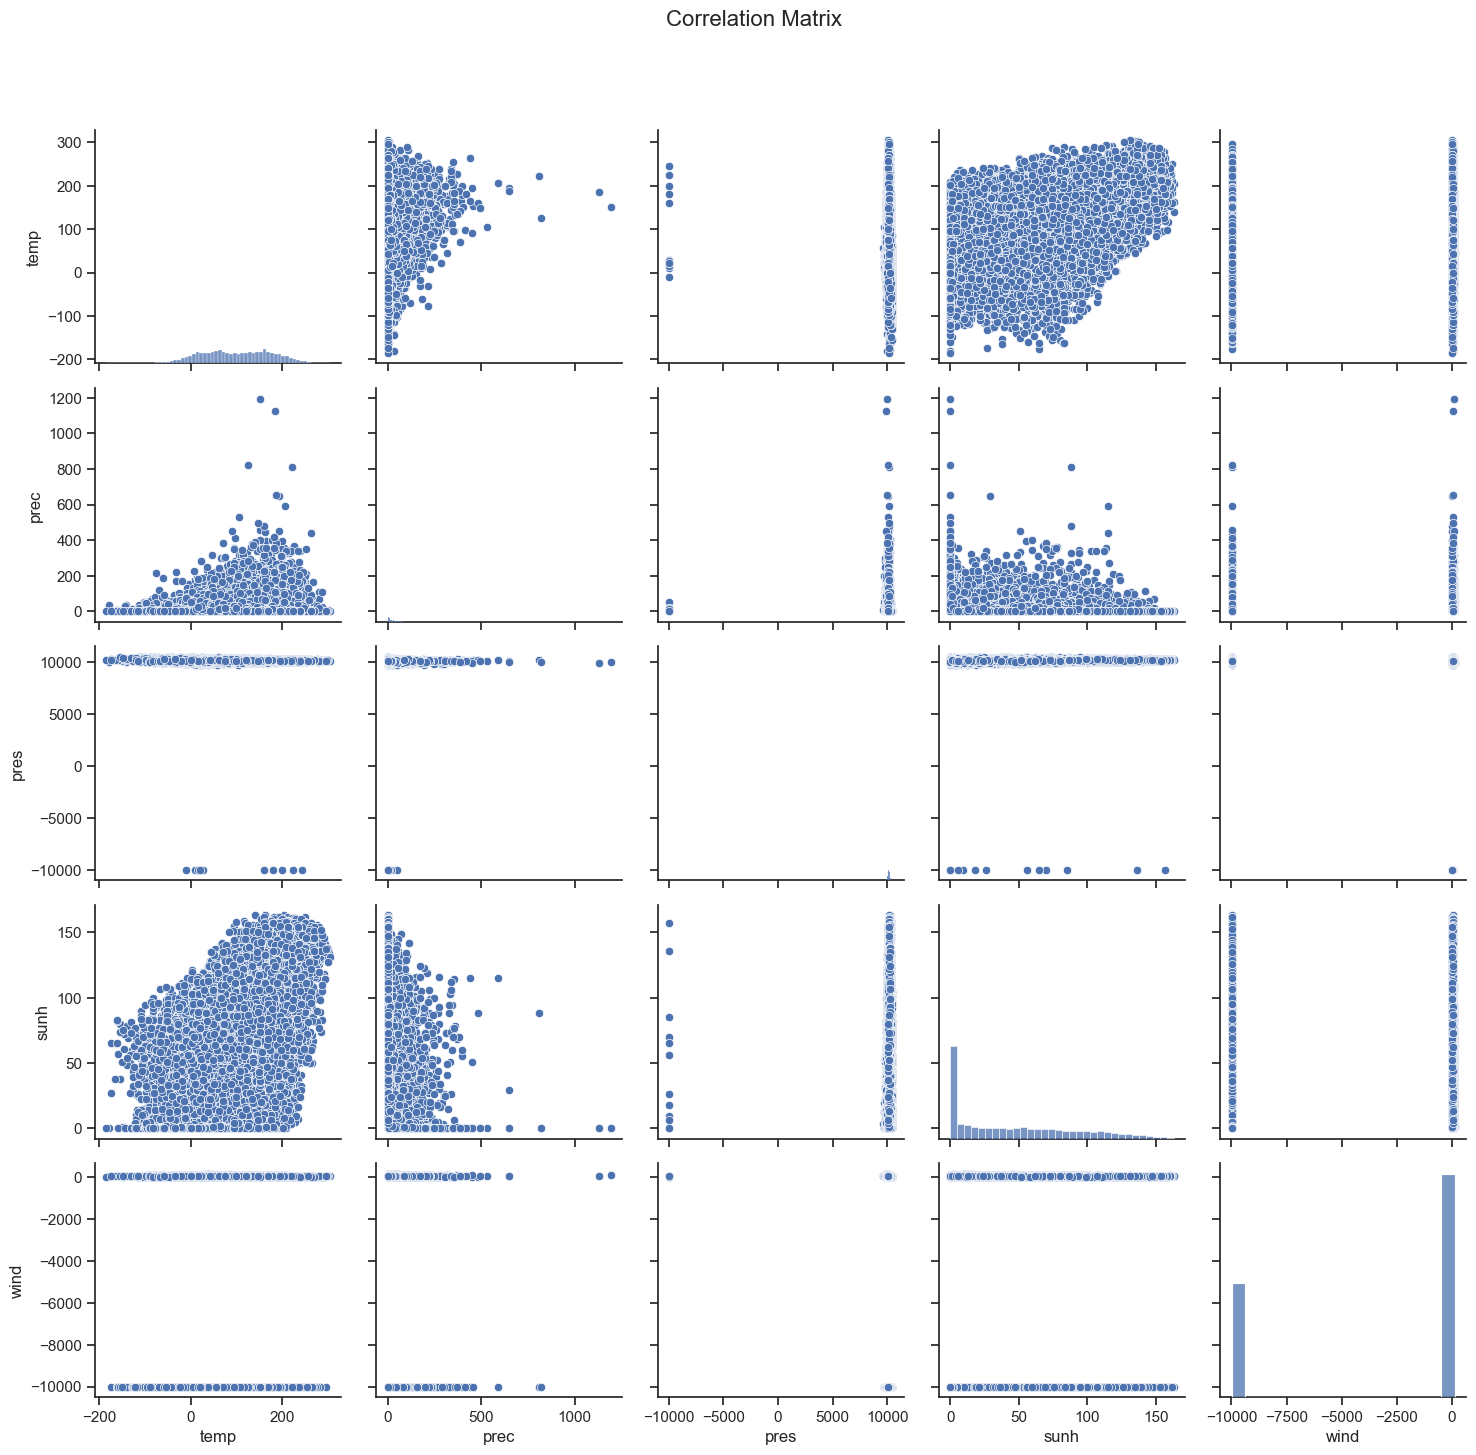

In [1149]:
sns.set_style('darkgrid')
sns.set(style="ticks", color_codes=True)
g = sns.PairGrid(df_copy[['temp', 'prec', 'pres', 'sunh', 'wind']])
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.fig.set_size_inches(15, 15)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Correlation Matrix', fontsize=16)
plt.show()

### Correlation Matrix

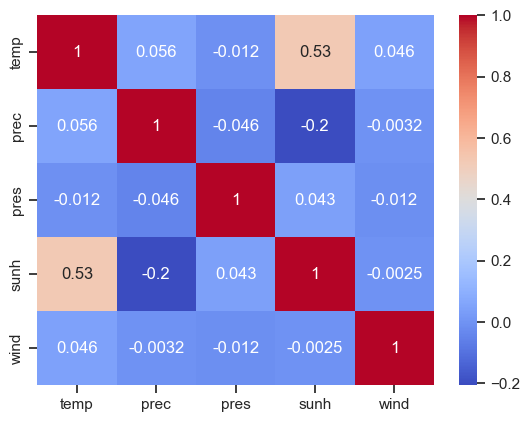

In [1150]:
# def pearson_corr(x, y):
#     n = len(x)
#     mean_x = np.mean(x)
#     mean_y = np.mean(y)
#     std_x = np.std(x, ddof=1)
#     std_y = np.std(y, ddof=1)
#     cov_xy = np.sum((x - mean_x) * (y - mean_y)) / (n - 1)
#     corr = cov_xy / (std_x * std_y)
#     return corr

# print(pearson_corr(df_copy['temp'], df_copy['prec']))

corr_matrix = df_copy[['temp', 'prec', 'pres', 'sunh', 'wind']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

* There is a moderate positive correlation between temperature and sunshine duration (0.53), which suggests that as temperature increases, the duration of sunshine also tends to increase.
* There is also a weak positive correlation between temperature and wind speed (0.05), which suggests that there may be some tendency for temperature and wind speed to increase together, although the correlation is not strong.
* There is a weak negative correlation between precipitation amount and sea level pressure (-0.05), which suggests that there may be some tendency for precipitation and sea level pressure to move in opposite directions, although the correlation is not strong.
* The other correlations (temperature and sea level pressure, precipitation and temperature, precipitation and wind speed, sea level pressure and sunshine duration, and wind speed and sunshine duration) are very weak or close to zero.

## Temperature Visual Exploration Over Time

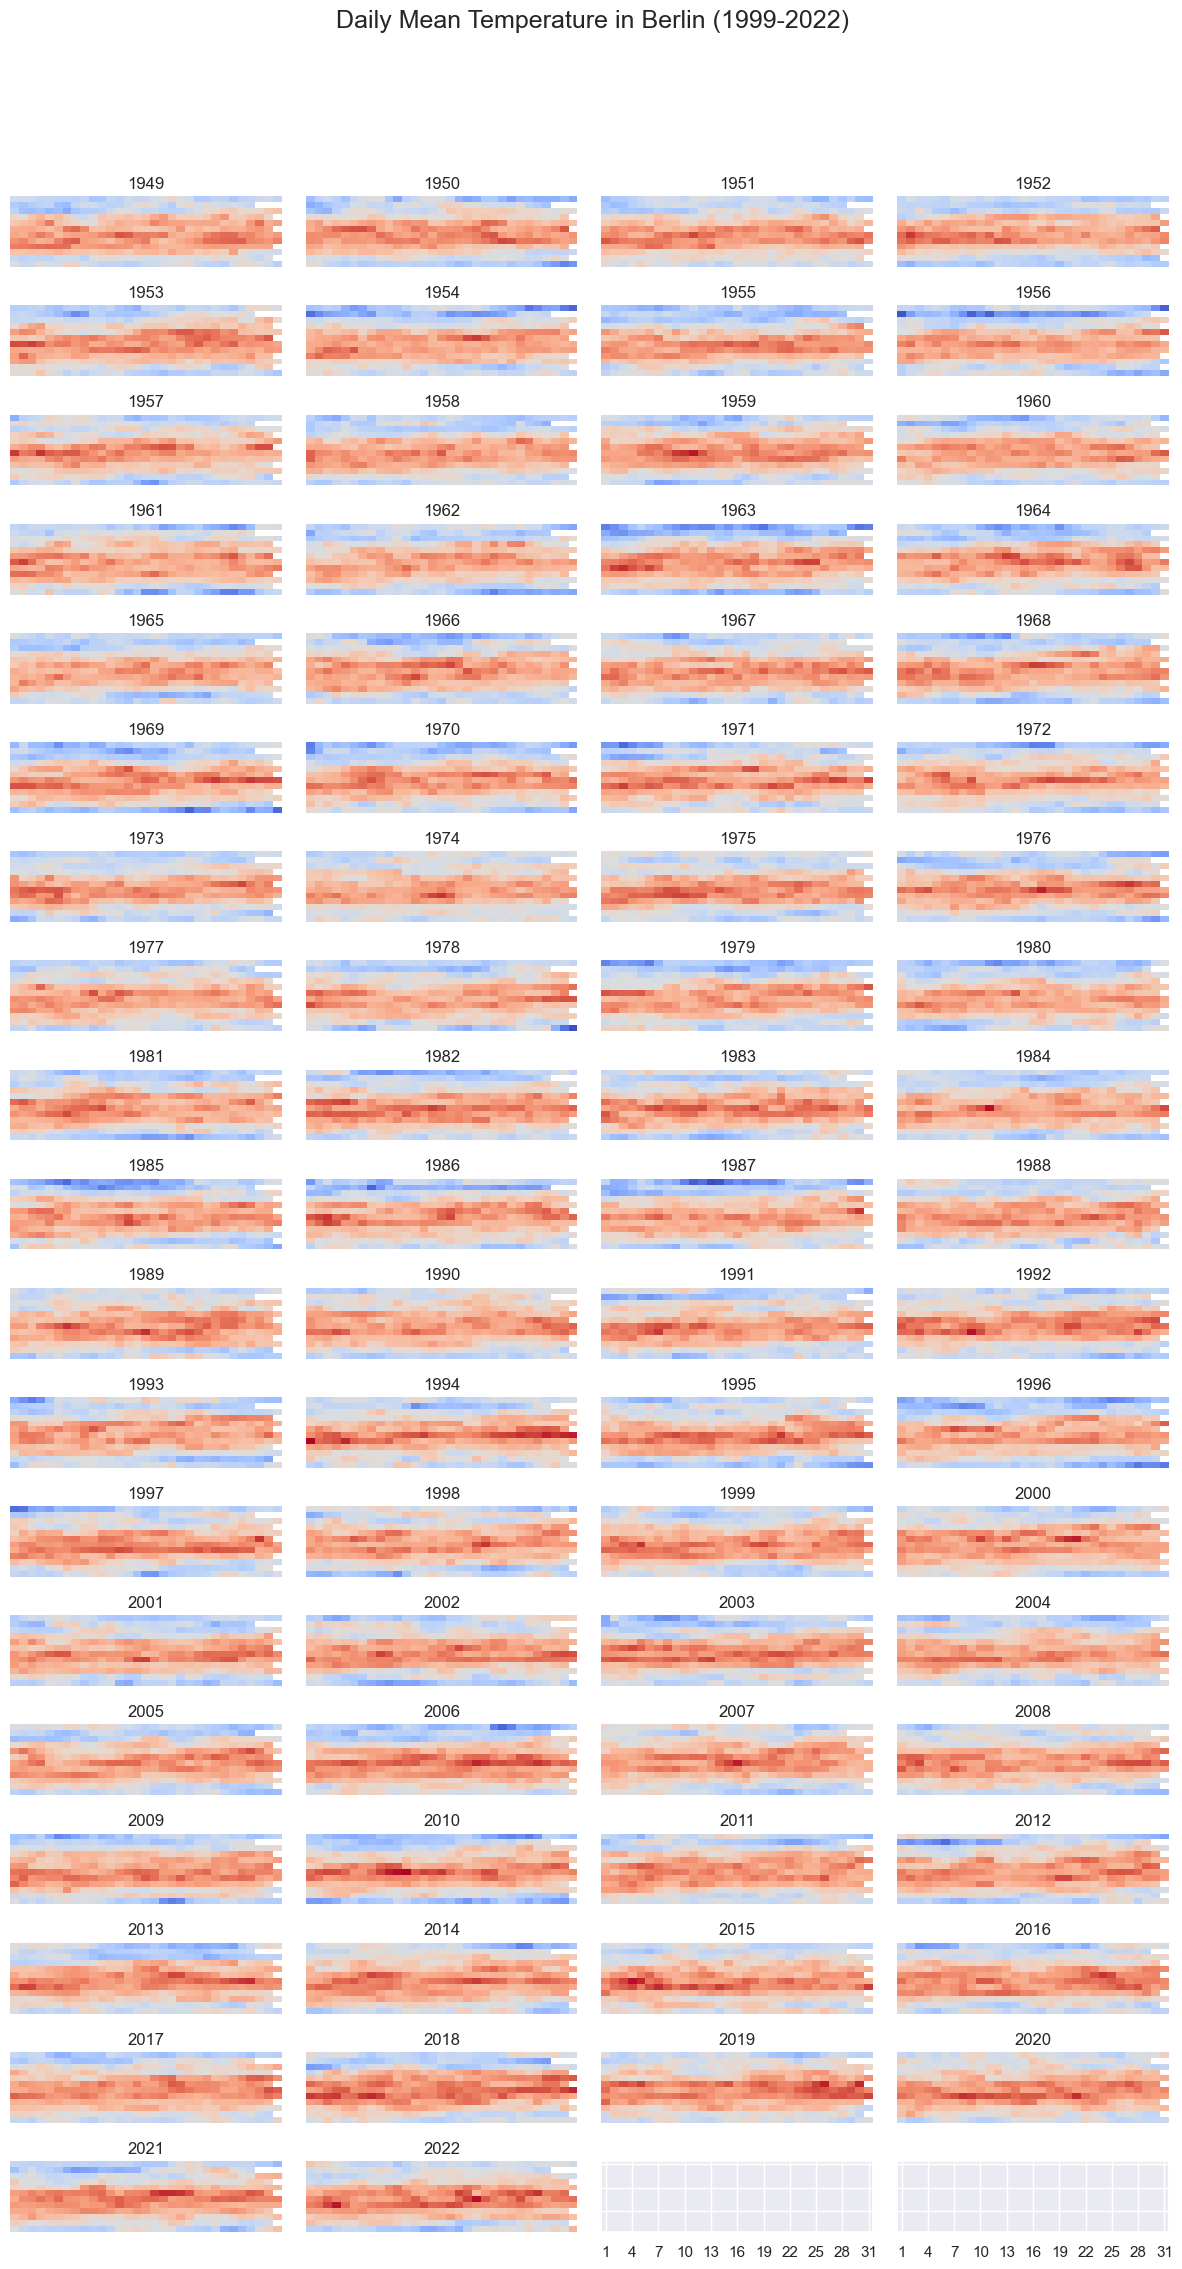

In [1155]:
years = range(1949, 2023)

num_plots = len(years)
num_rows, num_cols = divmod(num_plots, 4)
fig, axes = plt.subplots(nrows=num_rows+bool(num_cols), ncols=4, figsize=(12, 1.2*num_rows), sharex=True, sharey=True)

# Loop through the years and create a heatmap for each year
for i, year in enumerate(years):
    df_year = df[df['year'] == year]
    df_year_wide = df_year.pivot_table(index='month', columns='day', values='temp')
    ax = axes.flat[i]
    sns.heatmap(df_year_wide, cmap='coolwarm', cbar=False, ax=ax, vmin=df['temp'].min(), vmax=df['temp'].max())
    ax.set_title(f'{year}')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_axis_off()


#cbar_ax = fig.add_axes([0.2, 0.1, 0.02, 0.9])
#fig.colorbar(ax.collections[0], cax=cbar_ax, label='Temperature (°C)', ticks=np.arange(-10, 30, 5), pad=0.05, shrink=0.8, aspect=20, extend='both')

fig.suptitle('Daily Mean Temperature in Berlin (1999-2022)', fontsize=18, y=1.05)
fig.tight_layout()
plt.show()

### Create Heatmap GIF
Creating a heatmap GIF allows for a more intuitive visualization of how temperature patterns change over time. It provides an animated and dynamic view of the data, which can help in identifying trends and patterns that may not be apparent from a static heatmap.

In [1156]:
import os
import imageio
# Create a directory to save the output images
output_dir = 'data/output/berlin'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Loop through the years and create a heatmap image for each year
for year in range(1949, 2023):
    df_year = df[df['year'] == year]
    df_year_wide = df_year.pivot_table(index='month', columns='day', values='temp')
    sns.heatmap(df_year_wide, cmap='coolwarm', cbar=False)
    plt.title(f'{year}')
    plt.axis('off')
    # Save figure without border or padding
    plt.savefig(f'{output_dir}/{year}.png', bbox_inches='tight', pad_inches=0)
    plt.close()

In [1157]:
import imageio
dir_path = 'data/output/berlin'
file_list = os.listdir(dir_path)
file_list.sort()

images = []

for file_name in file_list:
    if file_name.endswith('.png'):
        file_path = os.path.join(dir_path, file_name)
        images.append(imageio.imread(file_path))

# Save the images as a GIF
imageio.mimsave('data/output/berlin/berlin_heatmap.gif', images, fps=2)

/var/folders/sl/g90lyn211sj69bdnk9qfl_gc0000gn/T/ipykernel_57993/110879981.py:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(file_path))
